<a href="https://colab.research.google.com/github/goransavich/cnn-xgboost/blob/main/cnn_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot
np.random.seed(1337)  # for reproducibility
#from keras.utils import np_utils
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Convolution1D, MaxPooling1D, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.regularizers import l2
from sklearn.utils import shuffle
#xgboost
import xgboost as xgb
import pandas as pd
from sklearn import metrics

In [130]:
from google.colab import files
uploaded = files.upload()
import io
import pandas as pd

train_name = list(uploaded.keys())[0]

train_df = pd.read_csv(io.BytesIO(uploaded[train_name]))

Saving Beef_TRAIN.csv to Beef_TRAIN (2).csv


In [131]:
uploaded = files.upload()

test_name = list(uploaded.keys())[0]

test_df = pd.read_csv(io.BytesIO(uploaded[test_name]))

Saving Beef_TEST.csv to Beef_TEST (2).csv


In [132]:
train_data = np.array(train_df)
test_data = np.array(test_df)
#train_data, test_data = shuffle(train_data, test_data)

In [133]:
x_train = train_data[:, :-1]
x_test = test_data[:, :-1]
train_y = train_data[:, -1:] 
test_y = test_data[:, -1:]

count_train = np.unique(train_y, return_counts=True)
count_test = np.unique(test_y, return_counts=True)

print(count_train[1])
print(count_test[1])

classes_in_dataset = len(np.unique(np.concatenate((train_y, test_y), axis=0)))

# transform the labels from integers to one hot vectors
enc = OneHotEncoder(categories='auto')
enc.fit(np.concatenate((train_y, test_y), axis=0).reshape(-1, 1))
y_train = enc.transform(train_y.reshape(-1, 1)).toarray()
y_test = enc.transform(test_y.reshape(-1, 1)).toarray()

x_train.shape
x_test.shape

[6 6 6 6 6]
[6 6 6 6 6]


(30, 470)

In [134]:
x_train,x_validate,y_train,y_validate = train_test_split(x_train,y_train,test_size = 0.1,random_state = 42)

In [135]:
if len(x_train.shape) == 2:  # if univariate
        # add a dimension to make it multivariate with one dimension 
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
input_shape = x_train.shape[1:]

print(input_shape)

print('Number of classes : {}'.format(classes_in_dataset))
###y_train for xgboost without encoding
y_train_xgboost = enc.inverse_transform(y_train)


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_validate.shape)
print(y_validate.shape)

(470, 1)
Number of classes : 5
(27, 470, 1)
(27, 5)
(30, 470, 1)
(30, 5)
(3, 470)
(3, 5)


In [142]:
inputs = input_shape
input_layer = Input(inputs)

conv2d1 = Convolution1D(filters=6, kernel_size=5, padding='valid')(input_layer)
activation1 = Activation('relu')(conv2d1)
maxpooling1 = MaxPooling1D(pool_size=2, strides=1, padding='valid')(activation1)
#dropout1 = Dropout(0.3)(maxpooling1)

conv2d2 = Convolution1D(filters=12, kernel_size=5, padding='valid')(maxpooling1)
activation2 = Activation('relu')(conv2d2)
maxpooling2 = MaxPooling1D(pool_size=2, strides=1, padding='valid')(activation2)
dropout2 = Dropout(0.1)(maxpooling2)

flatten = Flatten()(dropout2)

dense1 = Dense(512)(flatten) ##kernel_regularizer=l2(0.001)
activation3 = Activation('relu')(dense1)

dense2 = Dense(units=classes_in_dataset)(activation3)
activation4 = Activation('softmax')(dense2)

output_for_xgboost = Model(inputs=input_layer, outputs=flatten)
model = Model(inputs=input_layer, outputs=activation4)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model.compile(loss ='mean_squared_error', optimizer='Adam',metrics =['accuracy'])

history = model.fit(
    x_train,
    y_train,
    batch_size=4,
    epochs=400,
    verbose=1,
    #callbacks=[callback],
    validation_data=(x_validate,y_validate),
)

score = model.evaluate(x_test,y_test,verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))


Epoch 1/400
7/7 [==============================] - 1s 65ms/step - loss: 0.2242 - accuracy: 0.1481 - val_loss: 0.2612 - val_accuracy: 0.3333
Epoch 2/400
7/7 [==============================] - 0s 43ms/step - loss: 0.3030 - accuracy: 0.1111 - val_loss: 0.2443 - val_accuracy: 0.0000e+00
Epoch 3/400
7/7 [==============================] - 0s 42ms/step - loss: 0.2188 - accuracy: 0.2963 - val_loss: 0.1968 - val_accuracy: 0.0000e+00
Epoch 4/400
7/7 [==============================] - 0s 43ms/step - loss: 0.2041 - accuracy: 0.1852 - val_loss: 0.1530 - val_accuracy: 0.3333
Epoch 5/400
7/7 [==============================] - 0s 42ms/step - loss: 0.1873 - accuracy: 0.1852 - val_loss: 0.1883 - val_accuracy: 0.3333
Epoch 6/400
7/7 [==============================] - 0s 42ms/step - loss: 0.1669 - accuracy: 0.3704 - val_loss: 0.1357 - val_accuracy: 0.3333
Epoch 7/400
7/7 [==============================] - 0s 46ms/step - loss: 0.1664 - accuracy: 0.2222 - val_loss: 0.1370 - val_accuracy: 0.6667
Epoch 8/400


Text(0.5, 1.0, 'Train - Accuracy')

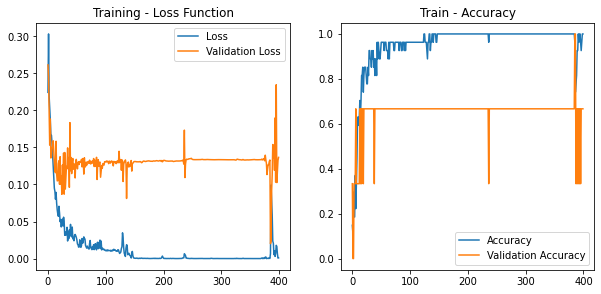

In [143]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

In [144]:
######### XGBOOST #############

intermediate_layer_model = output_for_xgboost

intermediate_layer_model.summary()

x_train_xgboost = intermediate_layer_model.predict(x_train)
x_test_xgboost = intermediate_layer_model.predict(x_test)

#label encoder for y to be in range from 0 to num-classes
def transform_labels(y_train_xgboost, test_y):
    le = preprocessing.LabelEncoder()
    y_t_xgboost = le.fit_transform(y_train_xgboost)
    t_y = le.fit_transform(test_y)
    return y_t_xgboost, t_y

y_tr_xgboost, test_y_xgboost = transform_labels(y_train_xgboost, test_y)

xgboost_train_dataset = np.concatenate([np.array(x_train_xgboost).reshape(x_train.shape[0],flatten.shape[1]),np.array(y_tr_xgboost).reshape(y_tr_xgboost.shape[0],1)],axis=1)
xgboost_train_dataset = pd.DataFrame(xgboost_train_dataset)
xgboost_train_dataset.to_csv('train_xgboost.csv',index=False)

xgboost_test_dataset = np.concatenate([np.array(x_test_xgboost).reshape(x_test.shape[0],flatten.shape[1]),np.array(test_y_xgboost).reshape(test_y_xgboost.shape[0],1)],axis=1)
xgboost_test_dataset = pd.DataFrame(xgboost_test_dataset)
xgboost_test_dataset.to_csv('test_xgboost.csv',index=False)

train_column = str(flatten.shape[1])

train = pd.read_csv('train_xgboost.csv')
train_y = train[train_column].astype('int')
train_x = train.drop([train_column],axis=1)

test = pd.read_csv('test_xgboost.csv')
test_y = test[train_column].astype('int')
test_x = test.drop([train_column],axis=1)

print(train_y.shape)
print(test_y.shape)

dataset = xgb.DMatrix(train_x, label=train_y)
watchlist = [(dataset, 'train')]
params = {'max_depth':6, 'eta':0.3, 'silent':1, 'num_class': classes_in_dataset} 
model_xg = xgb.train(params, dataset, num_boost_round=100)


test_x = xgb.DMatrix(test_x)
result = model_xg.predict(test_x)

Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 470, 1)]          0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 466, 6)            36        
_________________________________________________________________
activation_90 (Activation)   (None, 466, 6)            0         
_________________________________________________________________
max_pooling1d_39 (MaxPooling (None, 465, 6)            0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 461, 12)           372       
_________________________________________________________________
activation_91 (Activation)   (None, 461, 12)           0         
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 460, 12)           0  

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(27,)
(30,)


In [139]:

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix

#preds = model.predict(d_test)
#best_preds = np.asarray([np.argmax(line) for line in result])

print("Precision = {}".format(precision_score(test_y, result, average='macro', zero_division=0)))
print("Recall = {}".format(recall_score(test_y, result, average='macro', zero_division=0)))
print("Accuracy = {}".format(accuracy_score(test_y, result)))
print("F1 score = {}".format(f1_score(test_y, result, average='macro', zero_division=0)))

print(metrics.classification_report(test_y, result))
print(metrics.confusion_matrix(test_y, result))

Precision = 0.7386147186147187
Recall = 0.6666666666666667
Accuracy = 0.6666666666666666
F1 score = 0.627923057334822
              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.55      1.00      0.71         6
           2       1.00      0.17      0.29         6
           3       0.71      0.83      0.77         6
           4       0.60      0.50      0.55         6

    accuracy                           0.67        30
   macro avg       0.74      0.67      0.63        30
weighted avg       0.74      0.67      0.63        30

[[5 0 0 1 0]
 [0 6 0 0 0]
 [0 3 1 0 2]
 [1 0 0 5 0]
 [0 2 0 1 3]]
